In [1]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

from scipy.optimize import fmin_cobyla


from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# standard configurations
#get_ipython().magic('matplotlib inline')
#%config InlineBackend.figure_format = 'retina' # retina display

# in order to have fancy plots with lattice
def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

# Home-made truncated gaussian distribution
def trun_norm(cut):
    x = np.random.normal()
    return x+cut if np.abs(x)<cut else trun_norm(cut)


from matplotlib import rc

#rc('text', usetex=False)
rc('text', usetex=True)
rc('font', serif ='Times')
rc('font', size=16)
rc('axes', linewidth=0.5)
rc('lines', linewidth=1.15)
rc('figure', figsize=(8.3,5.2))
rc('grid', c='0.5', ls='--', lw=0.5)

/home/dmitrii/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [113]:
myString='''
! *********************************************************************
! Definition of parameters
! *********************************************************************

l_cell=100;
quadrupoleLenght=5;
f=30;
kf:=1/f/quadrupoleLenght;// m^-2
kd:=-1/f/quadrupoleLenght - kf/100;// m^-2

kn0_corr_00 := 0;
kn0_corr_01 := 0;
kn0_corr_10 := 0;
kn0_corr_11 := 0;
kn0_corr_20 := 0;
kn0_corr_21 := 0;
kn0_corr_30 := 0;
kn0_corr_31 := 0;
kn0_corr_40 := 0;
kn0_corr_41 := 0;
kn0_corr_50 := 0;
kn0_corr_51 := 0;

kn1_corr_0 :=0;
kn1_corr_1 :=0;
kn1_corr_2 :=0;
kn1_corr_3 :=0;
kn1_corr_4 :=0;
kn1_corr_5 :=0;

! *********************************************************************
! Definition of magnet
! ********************************************************************* 
QF: quadrupole, L=quadrupoleLenght, K1:=kf;
QD: quadrupole, L=quadrupoleLenght, K1:=kd;

CORR: HKICKER, L=1;
CORR_QD: MULTIPOLE;
BPM: MONITOR, L=1;

! *********************************************************************
! Definition of sequence
! *********************************************************************
myCell:sequence, refer=entry, L:=6*L_CELL;

CORR_KN0_00: CORR, hkick :=kn0_corr_00,         at=  1;
QF0: QF,                                        at= 10;
CORR_KN1_0: CORR_QD, knl:={0,kn1_corr_0},       at= 30;
CORR_KN0_01: CORR, hkick :=kn0_corr_01,         at= 50;
QD0: QD,                                        at= 60;
BPM0: BPM,                                      at= 75;

CORR_KN0_10: CORR, hkick :=kn0_corr_10,         at=101;
QF1: QF,                                        at=110;
CORR_KN1_1: CORR_QD, knl:={0,kn1_corr_1},       at=130;
CORR_KN0_11: CORR, hkick :=kn0_corr_11,         at=150;
QD1: QD,                                        at=160;
BPM1: BPM,                                      at=175;

CORR_KN0_20: CORR, hkick :=kn0_corr_20,         at=201;
QF2: QF,                                        at=210;
CORR_KN1_2: CORR_QD, knl:={0,kn1_corr_2},       at=230;
CORR_KN0_21: CORR, hkick :=kn0_corr_21,         at=250;
QD2: QD,                                        at=260;
BPM2: BPM,                                      at=275;

CORR_KN0_30: CORR, hkick :=kn0_corr_30,         at=301;
QF3: QF,                                        at=310;
CORR_KN1_3: CORR_QD, knl:={0,kn1_corr_3},       at=330;
CORR_KN0_31: CORR, hkick :=kn0_corr_31,         at=350;
QD3: QD,                                        at=360;
BPM3: BPM,                                      at=375;

CORR_KN0_40: CORR, hkick :=kn0_corr_40,         at=401;
QF4: QF,                                        at=410;
CORR_KN1_4: CORR_QD, knl:={0,kn1_corr_4},       at=430;
CORR_KN0_41: CORR, hkick :=kn0_corr_41,         at=450;
QD4: QD,                                        at=460;
BPM4: BPM,                                      at=475;

CORR_KN0_50: CORR, hkick :=kn0_corr_50,         at=501;
QF5: QF,                                        at=510;
CORR_KN1_5: CORR_QD, knl:={0,kn1_corr_5},       at=530;
CORR_KN0_51: CORR, hkick :=kn0_corr_51,         at=550;
QD5: QD,                                        at=560;
BPM5: BPM,                                      at=575;

endsequence;

! *********************************************************************
! Definition of beam
! *********************************************************************
beam, particle=proton, energy=2;

! *********************************************************************
! Use of the sequence
! *********************************************************************
use, sequence=myCell;

! *********************************************************************
! TWISS
! *********************************************************************
twiss;
'''


In [114]:
madx = Madx(stdout=False)
#madx = Madx()

madx.input(myString)

dxdy = [trun_norm(2.5) for i in range(2*4*6)]

madx.input('''
addquaderr(dx_err,dy_err,g1,g2,quadname): macro = {

rErr1n:=1e-4;
rErr1s:=1e-4;

SELECT, FLAG=error, clear;
eoption, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=0.0005*(dx_err-2.5), DY:=0.0005*(dy_err-2.5); 
EFCOMP, radius=0.03, order = 0, 
        dknr:={0,rErr1n*(g1-2.5)},
        dksr:={0,rErr1s*(g2-2.5)};
};''');

madx.input('''

exec, addquaderr({},{},{},{},QF0);
exec, addquaderr({},{},{},{},QD0);

exec, addquaderr({},{},{},{},QF1);
exec, addquaderr({},{},{},{},QD1);

exec, addquaderr({},{},{},{},QF2);
exec, addquaderr({},{},{},{},QD2);

exec, addquaderr({},{},{},{},QF3);
exec, addquaderr({},{},{},{},QD3);

exec, addquaderr({},{},{},{},QF4);
exec, addquaderr({},{},{},{},QD4);

exec, addquaderr({},{},{},{},QF5);
exec, addquaderr({},{},{},{},QD5);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;

'''.format(*dxdy))

DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]
qsPos = DF0[DF0["keyword"]=="quadrupole"]

err =madx.table.efield.dframe()
qsERR = err[err["name"].str.contains("q")]

#madx.input('''
#select,flag=interpolate, class=drift, slice=20, range=#s/#e;
#select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
#twiss;''')

myTwiss=madx.table.twiss.dframe()


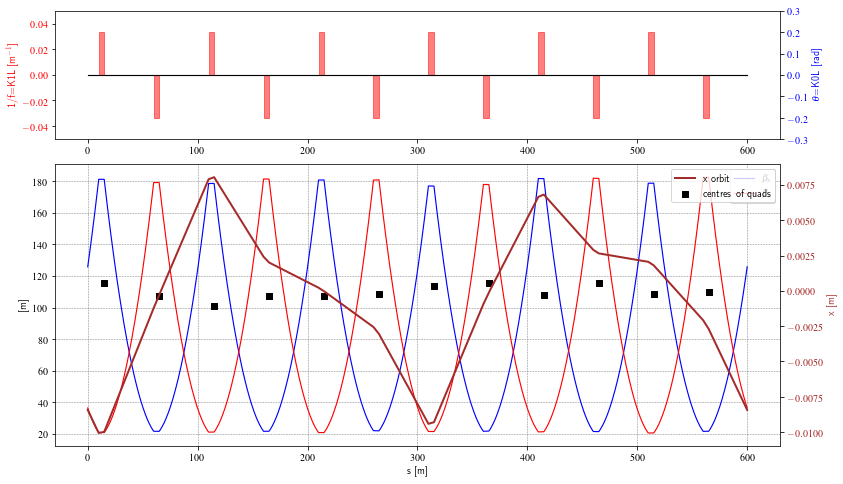

In [115]:
# just plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='hkicker')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    color = 'red'

DF=myTwiss[(myTwiss['keyword']=='hmonitor')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    color = 'black'

    
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.05,.05)
#plt.title(f'CAS-19, $\\mu_x$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f},\
#$\\mu_y$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f}')
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

    
plt.ylim(-.3,.3)

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.legend(loc='best')

plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwiss['s'],myTwiss['x'],'brown', label='x orbit', lw=2)
plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

ax3.set_ylabel('x [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.legend(loc='best')
#plt.ylim(0, 10);

In [127]:
# constraint for cobyla here
def con1(x):
    return 0.05*np.sqrt(2)-np.sum(x**2)
    

#=========================================================================================

# scalar function, it is the characterization of full X-orbit
# The argument is numpy array (list of kickers), len = 8
# returns dx/dk
def find_gradient_x(theta,flag):

    
    kf0 =1/30/5
    kd0 =-1/30/5-1/30/5/100
    delta = kf0/10

    madx.input('''kf ={}; kd ={};
    kn0_corr_00 := {};
    kn0_corr_01 := {};
    kn0_corr_10 := {};
    kn0_corr_11 := {};
    kn0_corr_20 := {};
    kn0_corr_21 := {};
    kn0_corr_30 := {};
    kn0_corr_31 := {};
    kn0_corr_40 := {};
    kn0_corr_41 := {};
    kn0_corr_50 := {};
    kn0_corr_51 := {}; 

    ;twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kf ={}; kd ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]

    vec = np.array(xbpm-xbpm0)/delta

    return np.linalg.norm(vec) if flag == True else vec 


#=========================================================================================



def find_orb_x(theta,flag):
    
    madx.input('''
    kf ={}; kd ={};
    select,flag=interpolate, class=quadrupole, slice=1, range=#s/#e;
    '''.format(1/30/5, -1/30/5-1/30/5/100))
      
    madx.input('''
    kn0_corr_00 := {};
    kn0_corr_01 := {};
    kn0_corr_10 := {};
    kn0_corr_11 := {};
    kn0_corr_20 := {};
    kn0_corr_21 := {};
    kn0_corr_30 := {};
    kn0_corr_31 := {};
    kn0_corr_40 := {};
    kn0_corr_41 := {};
    kn0_corr_50 := {};
    kn0_corr_51 := {};    
    twiss;
    '''.format(*theta));
    
    aux=madx.table.twiss.dframe()
    xq =aux[aux["keyword"]=="quadrupole"]["x"]
    
    aux =madx.table.efield.dframe()
    Qerr = aux[aux["name"].str.contains("q")]
    
    vec = np.array(np.array(xq)-np.array(Qerr["dx"]))
#    print(vec)

    return np.linalg.norm(vec) if flag == True else vec 




In [78]:
theta_x = np.zeros(12)
cons = [{"type": "ineq", "fun": con1}]
opt={'rhobeg': .00001, 'disp': True}

vec_xg = som(find_gradient_x, theta_x, method="COBYLA", constraints=cons, options=opt,args=(True,))
vec_xo = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options=opt,args=(True,))
print(vec_xg)
print(vec_xo)

     fun: 5.197315730021248
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 16
  status: 1
 success: True
       x: array([ 9.43905665e-06,  1.30257643e-06,  1.15648418e-05,  1.07160512e-05,
       -8.16698474e-07, -6.25026408e-07, -1.16145684e-06, -1.88351894e-07,
        1.14810538e-05,  1.06711125e-05, -9.17913556e-07, -5.63431120e-07])
     fun: 0.004666894784139646
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([-1.59007928e-05, -6.77177738e-06,  1.39542888e-05,  1.53874305e-05,
       -2.22552609e-05, -7.67122423e-06,  7.68896033e-06, -5.85183081e-06,
        8.12673433e-06,  9.23724190e-06,  3.03756273e-06,  1.06421029e-05])


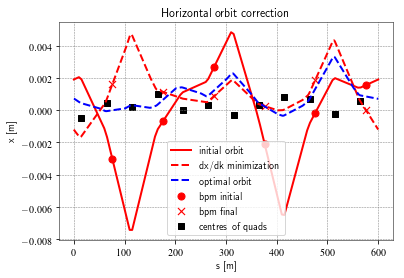

In [79]:
madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xg.x));

DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]

madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {}; 
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xo.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]

# plotting
# red dashed line stands for find_grad, blue dashed for find_orb

fig = plt.figure()
plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.scatter(bpmDF0.s,bpmDF0.x, color = "red", s = 50, label="bpm initial")

plt.plot(DF['s'],DF['x'],'r',ls="--", label='dx/dk minimization', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, color = "red", s = 50, marker="x", label="bpm final")

plt.plot(DF1['s'],DF1['x'],'blue',ls="--", label='optimal orbit', lw=2)

plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

plt.legend(loc='best')
plt.title("Horizontal orbit correction")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()


In [123]:
# this method applies errors to the lattice
# note, that all correctors are set to zero here
def add_err():

    dxdy = [trun_norm(2.5) for i in range(2*4*6)]

    out =madx.input('''
    
    kn0_corr_00 := 0;
    kn0_corr_01 := 0;
    kn0_corr_10 := 0;
    kn0_corr_11 := 0;
    kn0_corr_20 := 0;
    kn0_corr_21 := 0;
    kn0_corr_30 := 0;
    kn0_corr_31 := 0;
    kn0_corr_40 := 0;
    kn0_corr_41 := 0;
    kn0_corr_50 := 0;
    kn0_corr_51 := 0; 
    
    kn1_corr_0 :=0;
    kn1_corr_1 :=0;
    kn1_corr_2 :=0;
    kn1_corr_3 :=0;
    kn1_corr_4 :=0;
    kn1_corr_5 :=0;
    
    exec, addquaderr({},{},{},{},QF0);
    exec, addquaderr({},{},{},{},QD0);

    exec, addquaderr({},{},{},{},QF1);
    exec, addquaderr({},{},{},{},QD1);

    exec, addquaderr({},{},{},{},QF2);
    exec, addquaderr({},{},{},{},QD2);

    exec, addquaderr({},{},{},{},QF3);
    exec, addquaderr({},{},{},{},QD3);

    exec, addquaderr({},{},{},{},QF4);
    exec, addquaderr({},{},{},{},QD4);

    exec, addquaderr({},{},{},{},QF5);
    exec, addquaderr({},{},{},{},QD5);


    SELECT, FLAG = ERROR, FULL;
    ESAVE, FILE = err.txt;

    twiss;

    '''.format(*dxdy))
    return out




In [82]:
bpms = list(myTwiss[myTwiss["keyword"]=="hmonitor"]["name"])
other =["n", "dx(q)"]
corrs = ["kn0_corr_{}{}".format(i//2,i%2) for i in range(12)]

cols = bpms+other+corrs


def make_train_data():

    df_tmp = pd.DataFrame(columns=cols)

    for i in range(100):
        a = add_err()
        if a:
            dxdk0 =find_gradient_x(np.zeros(len(corrs)), False)
       
            tmp =dict()
            for i,x in enumerate(dxdk0):
                tmp[bpms[i]]=x
              
            theta_x = np.zeros(len(corrs))

            vec = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options=opt, args=(True,))

            for i,x in enumerate(vec.x):
                tmp[corrs[i]]=x
        
#            tmp["dx/dk(0)"]= dxdk0
            tmp["n"]= vec.nfev
            tmp["dx(q)"]= vec.fun
        
            #this step is required to indetify, where the optimizer found totally wrong sollution
            if np.linalg.norm(dxdk0) > find_gradient_x(vec.x,True):
                df_tmp =df_tmp.append(tmp,ignore_index=True)
            else:
                print("warn! the optimum sollution not found")
            
    return df_tmp

df = make_train_data()
df.to_csv("inverse_regression.csv",index=False)

#df = pd.read_csv("inverse_regression.csv")

warn! the optimum sollution not found
warn! the optimum sollution not found
warn! the optimum sollution not found
warn! the optimum sollution not found
warn! the optimum sollution not found


In [83]:
max_depth = 3
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=20,max_depth=max_depth, random_state=10))

feature_cols = bpms
target_cols = corrs

A = np.linalg.norm(df[target_cols])
X = df[feature_cols]
Y = df[target_cols]/A
n = len(df)
#print(n)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=int(8*n/10), test_size=n-int(8*n/10), random_state=1)

regr_multirf.fit(X_train, Y_train)
y_multirf = regr_multirf.predict(X_test)

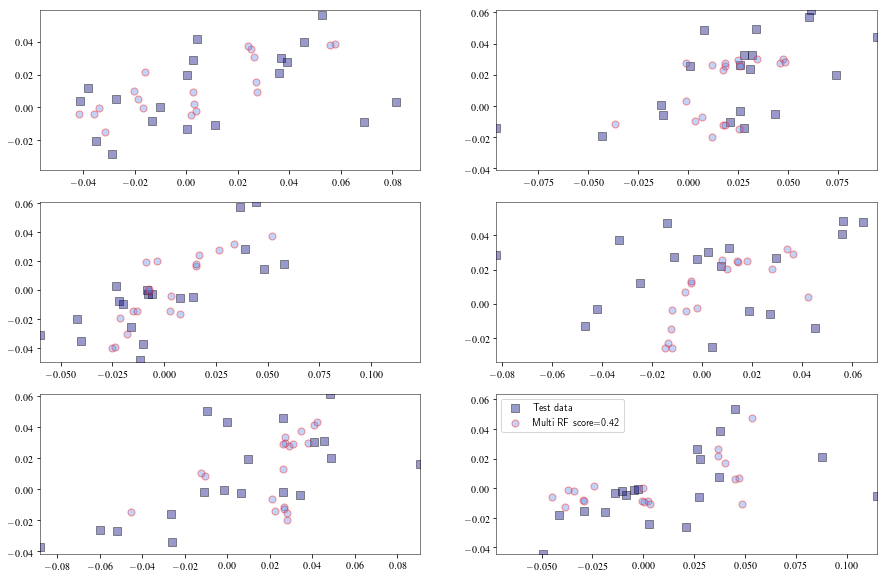

In [84]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(10)
fig.set_figwidth(15)

s = 50
a = 0.4

[axs[i//2,i%2].scatter(Y_test[corrs[2*i]],Y_test[corrs[2*i+1]], 
                       edgecolor='k', c="navy", s=s, marker="s", alpha=a, label="Test data") for i in range(6)]


[axs[i//2,i%2].scatter(y_multirf[:, 2*i], y_multirf[:, 2*i+1], edgecolor='r',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, Y_test) ) for i in range(6)]


[axs[i//2,i%2].set_xlim([Y[corrs[2*i]].min(), Y[corrs[2*i]].max()]) for i in range(6)]
[axs[i//2,i%2].set_ylim([Y[corrs[2*i+1]].min(), Y[corrs[2*i+1]].max()]) for i in range(6)]


plt.legend()
plt.show()

In [128]:
a=add_err()
print(a)
aux =madx.table.efield.dframe()
qsERR1 = aux[aux["name"].str.contains("q")]
    
DF0=madx.table.twiss.dframe()
dxdk0 =find_gradient_x(np.zeros(12), False)
print(dxdk0)

vec_predict = regr_multirf.predict([dxdk0])*A

madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_predict[0]));

DF=madx.table.twiss.dframe()


fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.plot(DF['s'],DF['x'],'blue',ls="--", label='Rand forest prediction', lw=2)

plt.legend()
plt.title("Horizontal orbit")
plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()
plt.show()

True
[]


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

In [105]:
vec_xg_dt = som(find_gradient_x, vec_predict[0], method="COBYLA", constraints=cons, options=opt,args=(True,))

vec_xg = som(find_gradient_x, np.zeros(12), method="COBYLA", constraints=cons, options=opt,args=(True,))
vec_xo = som(find_orb_x, np.zeros(12), method="COBYLA", constraints=cons, options=opt,args=(True,))

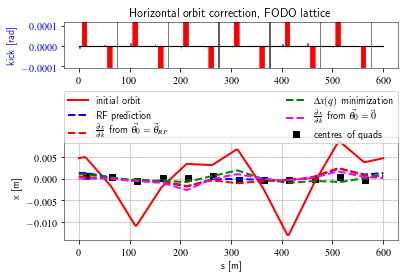

In [106]:
madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_predict[0]));

DF=madx.table.twiss.dframe()

madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xg_dt.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]


madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xo.x));

DF2=madx.table.twiss.dframe()

madx.input('''
kn0_corr_00 := {};
kn0_corr_01 := {};
kn0_corr_10 := {};
kn0_corr_11 := {};
kn0_corr_20 := {};
kn0_corr_21 := {};
kn0_corr_30 := {};
kn0_corr_31 := {};
kn0_corr_40 := {};
kn0_corr_41 := {};
kn0_corr_50 := {};
kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
twiss;'''.format(*vec_xg.x));

DF3=madx.table.twiss.dframe()

# plotting
fig = plt.figure()
fig.subplots_adjust(hspace=0.25)
ax1=plt.subplot2grid((4,3), (0,0), colspan=3, rowspan=1)
ax1.set_title("Horizontal orbit correction, FODO lattice")
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

tmp=DF1[DF1['keyword']=='quadrupole']
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

hk = []
tmp=DF1[(DF1['keyword']=='hkicker')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    hk.append(aux.hkick)
    color = 'red'

tmp=DF1[(DF1['keyword']=='hmonitor')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=-0.005, color='black')
    color = 'blue'

    
#ax1.set_ylabel(r'hkick [$\delta p_y /p_0$]', color=color)
ax1.set_ylabel(r'kick [rad]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(min(hk)-10**(-4),max(hk)+10**(-4))

axbeta=plt.subplot2grid((4,3), (2,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.plot(DF['s'],DF['x'],'blue',ls="--", label='RF prediction', lw=2)
plt.plot(DF1['s'],DF1['x'],'red',ls="--", label=r'$\frac{\partial x}{\partial k}$ from $\vec{\theta_0}=\vec{\theta}_{RF}$', lw=2)
plt.plot(DF2['s'],DF2['x'],'green',ls="--", label=r'$\Delta x(q)$ minimization', lw=2)
plt.plot(DF3['s'],DF3['x'],'magenta',ls="--", label=r'$\frac{\partial x}{\partial k}$ from $\vec{\theta_0}=\vec{0}$', lw=2)
plt.scatter(qsPos.s,qsERR1.dx, label="centres of quads", marker = "s", color = "black")

#plt.ylim([-0.03,0.04])

#plt.scatter(bpmDF1.s,bpmDF1.x, color = "red", s = 50, marker="x", label="bpm final")

#plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(0., 0.94, 1., .01), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#l1 =plt.legend([p1,p2,p3],['initial orbit','RF prediction','dx/dk from RF prediction'], loc=1)
#l2 =plt.legend([p4,p5,p6],['dx(q) minimization','dx/dk from zero',"centres of quads"], loc=4)
#plt.gca().add_artist(l1)


plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()

#plt.savefig("FODO_corr.pdf")

In [112]:
vectors = [np.zeros(12),vec_predict[0], vec_xg, vec_xg_dt, vec_xo]
names = ["zero","RF prediction", "dx/dk from zero", "dx/dk from prediction", "dx(q) from zero"]
df1 = pd.DataFrame(columns=["type","final dx/dk","final dx(q)", "opt. steps"])

for i,vec in enumerate(vectors):
    if i>1:
        g = find_gradient_x(vec.x,True)
        qo = find_orb_x(vec.x,True)
        n = vec.nfev
    else:
        g = find_gradient_x(vec,True)
        qo = find_orb_x(vec,True)
        n = 1
    df1 = df1.append({"type":names[i],"final dx/dk":g,"final dx(q)":qo, "opt. steps":n}, ignore_index=True)
    
df1

,type,final dx/dk,final dx(q),opt. steps
0,zero,19.780764,0.012150,1
1,RF prediction,1.309678,0.003381,1
2,dx/dk from zero,2.274883,0.003676,25
3,dx/dk from prediction,1.539620,0.003380,14
4,dx(q) from zero,4.463744,0.002812,38


In [116]:
def periodic_beta(theta):
    
    madx.input('''
    kn1_corr_0 :={};
    kn1_corr_1 :={};
    kn1_corr_2 :={};
    kn1_corr_3 :={};
    kn1_corr_4 :={};
    kn1_corr_5 :={};
    twiss;'''.format(*theta) );
    
    aux = madx.table.twiss.dframe()
    tmp=aux[aux["keyword"]=="monitor"]

    metric_x = tmp["betx"].std()/tmp["betx"].mean()
    metric_y = tmp["bety"].std()/tmp["bety"].mean()


        
    metric = metric_x+metric_y
    print(metric)
        
    return  metric   

In [119]:
theta_x = np.zeros(6)
#theta_x = np.random.normal(0,0.005,6)

def con3(theta):
    return 0.02-np.linalg.norm(theta)*np.sqrt(len(theta))

cons = [{"type": "ineq", "fun": con3}]
options_dict = {'rhobeg': .00001, 'disp': True}

vec_beta_per = som(periodic_beta, theta_x, method="COBYLA", constraints=cons, options=options_dict)


0.01761092245899329
0.017443698435809462
0.01757928792382859
0.017303532722464054
0.017435414009635043
0.017036562279566413
0.017343980408794427
0.016564855985053736
0.016122325804405514
0.01571428072460414
0.015328790800386289
0.015112779630301505
0.014955900740566859
0.014830276162279873
0.01464850262105171
0.014344338307470828
0.014043975568733337
0.01377518834445237
0.013639694957850269
0.013487507056289752
0.013294042708141638
0.013120683716243305
0.013057326818770578
0.01285163902191959
0.012668706698231726
0.012489435952632556
0.012368920569934428
0.012215456843760042
0.01217147457781053
0.012144683379628325
0.012050882469870303
0.011890803848347085
0.011737475148030758
0.01158144945596372
0.011470305182178706
0.01130271785544165
0.011268326328572211
0.011345054228557049
0.011259289451961503
0.011291237763575565
0.01110604028633373
0.011504228396435338
0.011042859565147974
0.011044668748823004
0.010968991760507129
0.011329190143336521


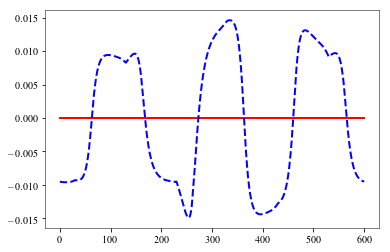

In [121]:
madx.input('''
kn1_corr_0 :={};
kn1_corr_1 :={};
kn1_corr_2 :={};
kn1_corr_3 :={};
kn1_corr_4 :={};
kn1_corr_5 :={};
twiss;'''.format(*vec_beta_per.x) );

DF1 = madx.table.twiss.dframe()
plt.plot(DF0['s'],(DF0['betx']-myTwiss['betx'])/myTwiss['betx'],'r', label='beta-beat initial', lw=2)
plt.plot(DF1['s'],(DF1['betx']-myTwiss['betx'])/myTwiss['betx'],'b', label='beta-beat model', lw=2, ls="--")

In [135]:
opt_dict = {'rhobeg': .00001, 'disp': True}

#dxdk_start, dxdk_mrf, dxdk_rf, dxdk_zero, dxdk_fin, dxdk_quads = [],[],[],[],[],[]
#dxq_start, dxq_mrf, dxq_rf, dxq_zero, dxq_fin, dxq_quads = [],[],[],[],[],[]
#n_zero, n_fin, n_quads = [],[],[]

for i in range(50):

    add_err()
    DF0=madx.table.twiss.dframe()
    x0 = np.array(DF0[DF0["keyword"]=="hmonitor"]["x"])[0]
    dxdk0 =find_gradient_x(np.zeros(2))
    dx0 = find_orb_x(np.zeros(2))
    
    dxdk_start.append(dxdk0)
    dxq_start.append(dx0)
    

    vec_predict_mrf = regr_multirf.predict([[x0,dxdk0]])[0]*A
    dxdk_mrf.append(find_gradient_x(vec_predict_mrf))
    dxq_mrf.append(find_orb_x(vec_predict_mrf))    

    vec_predict_rf = regr_rf.predict([[x0,dxdk0]])[0]*A
    dxdk_rf.append(find_gradient_x(vec_predict_rf))
    dxq_rf.append(find_orb_x(vec_predict_rf))    
    
    
    
    vec_xg_dt = som(find_gradient_x, vec_predict_rf, method="COBYLA", constraints=cons, options=opt_dict)
    dxdk_fin.append(find_gradient_x(vec_xg_dt.x))
    dxq_fin.append(find_orb_x(vec_xg_dt.x)) 
    n_fin.append(vec_xg_dt.nfev)
    
    vec_xg = som(find_gradient_x, np.zeros(2), method="COBYLA", constraints=cons, options=opt_dict)
    dxdk_zero.append(find_gradient_x(vec_xg.x))
    dxq_zero.append(find_orb_x(vec_xg.x))
    n_zero.append(vec_xg.nfev)

    vec_xo = som(find_orb_x, np.zeros(2), method="COBYLA", constraints=cons, options=opt_dict)
    dxdk_quads.append(find_gradient_x(vec_xo.x))
    dxq_quads.append(find_orb_x(vec_xo.x))    
    n_quads.append(vec_xo.nfev)
    



In [136]:
df2 = pd.DataFrame(columns=["type","final dx/dk","final dx(q)", "opt. steps"])

df2 = df2.append({"type":"zero","final dx/dk":np.mean(dxdk_start),"final dx(q)":np.mean(dxq_start), "opt. steps":0}, ignore_index=True)
df2 = df2.append({"type":"mrf prediction","final dx/dk":np.mean(dxdk_mrf),"final dx(q)":np.mean(dxq_mrf), "opt. steps":1}, ignore_index=True)
df2 = df2.append({"type":"rf prediction","final dx/dk":np.mean(dxdk_rf),"final dx(q)":np.mean(dxq_rf), "opt. steps":1}, ignore_index=True)
df2 = df2.append({"type":"dx/dk from rf prediction","final dx/dk":np.mean(dxdk_fin),"final dx(q)":np.mean(dxq_fin), "opt. steps":int(np.mean(n_fin))}, ignore_index=True)
df2 = df2.append({"type":"dx/dk from zero","final dx/dk":np.mean(dxdk_zero),"final dx(q)":np.mean(dxq_zero), "opt. steps":int(np.mean(n_zero))}, ignore_index=True)
df2 = df2.append({"type":"dx(q) from zero","final dx/dk":np.mean(dxdk_quads),"final dx(q)":np.mean(dxq_quads), "opt. steps":int(np.mean(n_quads))}, ignore_index=True)

df2

,type,final dx/dk,final dx(q),opt. steps
0,zero,2.504634,0.014188,0
1,mrf prediction,1.201575,0.007208,1
2,rf prediction,1.225661,0.007114,1
3,dx/dk from rf prediction,0.139587,0.003774,13
4,dx/dk from zero,0.143209,0.006786,23
5,dx(q) from zero,0.193952,0.002631,92
